Нужные библиотеки

In [2]:
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline 

In [3]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина комментария
max_description_len = 50

Загрузка набора данных

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/bed_type_data/datasets/model_data.csv', index_col=[0])
dataset = dataset.sample(frac=1) #перемешиваем строки в случайном порядке для равномерности

Проверка данных


In [5]:
dataset

,description,double,twin,queen,king,single,other,undefined
8292,1 KING DELUXE NONSMOKING; YOU CAN KEEP YOURSEL...,0,0,0,1,0,0,0
884,2 Double bed deluxe room relax in a comfortabl...,1,1,0,0,0,0,0
2060,"Brown-forman, 0.1 Km, includes breakfast, wifi...",0,0,0,1,0,0,0
426,BESTREZ RO INC VAT\nExecutive Double Ensuite W...,1,0,0,0,0,0,0
12103,1 Sgl bed nonsmoking log on to your email with...,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
11258,AT KEARNEY INC. BREAKFAST INCLUDED.\nSUPERIOR-...,0,0,1,0,0,0,0
1299,"2 Double beds,nsmk,city vw,hi speed net,cofmkr...",1,1,0,0,0,0,0
889,Standard Double Room - Breakfast included in t...,1,0,0,0,0,0,0
6780,"Pepsico, 1.9 Km, includes breakfast, wifi, par...",0,0,0,1,0,0,0


Выделяем данные для обучения

In [6]:
train_part = dataset[:9176] #0.7 part for training
test_part = dataset[9176:] #0.3 part for testing

In [7]:
descriptions_set = train_part['description']

In [8]:
descriptions_set

8292     1 KING DELUXE NONSMOKING; YOU CAN KEEP YOURSEL...
884      2 Double bed deluxe room relax in a comfortabl...
2060     Brown-forman, 0.1 Km, includes breakfast, wifi...
426      BESTREZ RO INC VAT\nExecutive Double Ensuite W...
12103    1 Sgl bed nonsmoking log on to your email with...
                               ...                        
8049     FLEXIBLE RATE - BB\nExecutive-Zimmer mit 1 Kin...
1470     Double Room with Two Double Beds and Sofa bed ...
7436     Comcast global recognition, includes wifi, won...
12117    Urban, 2 Twin/Single Bed(s), Sofa bed, Mini fr...
7751     1 King bed nonsmoking\nhdtv/free wi-fi/hot bre...
Name: description, Length: 9176, dtype: object

Выделяем правильные ответы

In [9]:
y_train = train_part[['double', 'twin',	'queen',	'king',	'single',	'other']]
y_train

,double,twin,queen,king,single,other
8292,0,0,0,1,0,0
884,1,1,0,0,0,0
2060,0,0,0,1,0,0
426,1,0,0,0,0,0
12103,0,0,0,0,1,0
...,...,...,...,...,...,...
8049,0,0,0,1,0,0
1470,1,1,0,0,0,0
7436,0,0,0,1,0,0
12117,0,1,0,0,1,0


Токенизация текста

In [10]:
#Создаем токенизатор Keras
tokenizer = Tokenizer(num_words=num_words)
#Обучаем токенизатор на description`s
tokenizer.fit_on_texts(descriptions_set)

In [11]:
#Просматриваем словарь токенизатора
tokenizer.word_index

{'policy': 1,
 'room': 2,
 'and': 3,
 'for': 4,
 'in': 5,
 'free': 6,
 'commission': 7,
 'a': 8,
 '1': 9,
 'children': 10,
 'the': 11,
 'check': 12,
 'of': 13,
 'to': 14,
 'king': 15,
 'rate': 16,
 'bed': 17,
 'out': 18,
 'with': 19,
 'wifi': 20,
 'stay': 21,
 'per': 22,
 '10': 23,
 'group': 24,
 'are': 25,
 'is': 26,
 '2': 27,
 'or': 28,
 'pet': 29,
 'night': 30,
 'on': 31,
 'hotel': 32,
 'internet': 33,
 'rooms': 34,
 '00': 35,
 'all': 36,
 'child': 37,
 'guest': 38,
 'breakfast': 39,
 'family': 40,
 'be': 41,
 'pets': 42,
 'allowed': 43,
 'early': 44,
 'fee': 45,
 'please': 46,
 'service': 47,
 'percent': 48,
 'maximum': 49,
 'late': 50,
 'conditions': 51,
 '0': 52,
 'usd': 53,
 'starting': 54,
 'tv': 55,
 'rates': 56,
 'not': 57,
 'at': 58,
 'extra': 59,
 'non': 60,
 'guests': 61,
 'will': 62,
 'occupancy': 63,
 'taxes': 64,
 'max': 65,
 'their': 66,
 'under': 67,
 'wireless': 68,
 'queen': 69,
 'parents': 70,
 'includes': 71,
 'coffee': 72,
 'no': 73,
 'years': 74,
 'may': 75,
 'c

In [12]:
#Преобразуем описания в числовое представление
sequences = tokenizer.texts_to_sequences(descriptions_set)

In [13]:
print(tokenizer.word_index['2'], tokenizer.word_index['double'])


27 79


Ограничиваем длину отзывов

In [14]:
x_train = pad_sequences(sequences, maxlen=max_description_len)

In [15]:
x_train[:5]

array([[1264,  154,   14,  335,   19,  130,  710,   91,   68,   33,    5,
          11,  514,   13,  130,  308,  975,  266,    2,  534,   26,    8,
         406,  145,    3,  440,   14, 5418,  130,  115,  333,   76, 5419,
          31,   11,  319,  207,  187,  226,   55,    2,   16,  899, 4595,
           3,  877,   62, 5420, 7117,  162],
       [ 137,  263,    4,    8,  220,   30,    7,    1,    7,  147,   31,
          36,  250,  259,  199,  182,    5,  128,  238,  144,   66,    7,
         240,    5,   66,  242,  174,  251,  102,   12,   19,    8,  260,
         261,   13,   36,   32,  140,   26,  262,   14,   96,  201,  124,
          11,  255,  149,  115,  128,  236],
       [ 505,   71,   39,   20,  134,  313,  347, 1172,   15, 2816,   38,
           2,    9,   15, 1077, 2663,   65,   63,   27,   61,    2,    9,
          15,  191,   17,    9,   15,  101,   94, 5421, 3664,   68,   33,
          76,  181,   33,   76,   59,   37,   52,   53,   10,  205,   57,
          21,    6,   

Cеть LSTM

In [16]:
model_lstm = Sequential()
model_lstm.add(Embedding(num_words, 128, input_length=max_description_len))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(40, return_sequences=True))
model_lstm.add(LSTM(40))
model_lstm.add(Dense(6, activation='sigmoid'))

In [17]:
model_lstm.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'AUC'])

In [18]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 128)           1280000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50, 40)            27040     
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 1,320,246
Trainable params: 1,320,246
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [19]:
model_lstm_save_path = 'best_model_lstm.h5'
checkpoint_callback_lstm = ModelCheckpoint(model_lstm_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [20]:
history_lstm = model_lstm.fit(x_train, 
                              y_train, 
                              epochs=85,
                              batch_size=140,
                              validation_split=0.2,
                              callbacks=[checkpoint_callback_lstm])

Epoch 1/85
53/53 [==============================] - 11s 50ms/step - loss: 0.4513 - accuracy: 0.5793 - auc: 0.7597 - val_loss: 0.3609 - val_accuracy: 0.5980 - val_auc: 0.8179

Epoch 00001: val_accuracy improved from -inf to 0.59804, saving model to best_model_lstm.h5
Epoch 2/85
53/53 [==============================] - 2s 31ms/step - loss: 0.3593 - accuracy: 0.5944 - auc: 0.8161 - val_loss: 0.3581 - val_accuracy: 0.5980 - val_auc: 0.8305

Epoch 00002: val_accuracy did not improve from 0.59804
Epoch 3/85
53/53 [==============================] - 2s 30ms/step - loss: 0.3439 - accuracy: 0.5944 - auc: 0.8404 - val_loss: 0.3154 - val_accuracy: 0.6024 - val_auc: 0.8659

Epoch 00003: val_accuracy improved from 0.59804 to 0.60240, saving model to best_model_lstm.h5
Epoch 4/85
53/53 [==============================] - 2s 30ms/step - loss: 0.2992 - accuracy: 0.6579 - auc: 0.8855 - val_loss: 0.2905 - val_accuracy: 0.6737 - val_auc: 0.8877

Epoch 00004: val_accuracy improved from 0.60240 to 0.67375, s

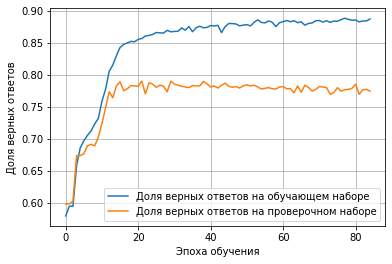

In [21]:
plt.plot(history_lstm.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе',)
plt.plot(history_lstm.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе',)
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.grid()
plt.show()

Тестирование

In [22]:
test_part[:5]

,description,double,twin,queen,king,single,other,undefined
1946,1 King bed study with sofabed nonsmoking\nhdtv...,0,0,0,1,0,0,0
5600,1Kg mobility/hearing access ri shwr nonsmok\n...,0,0,0,1,0,0,0
1677,1 DBL BED NONSMOKE; MAKE YOURSELF AT HOME IN T...,1,0,0,0,0,0,0
8921,"1 King Bed, Guest room, 1 King - Non-refundabl...",0,0,0,1,0,0,0
6081,1 King bed\n302 sqft-wifi avail-refrig-sweet d...,0,0,0,1,0,0,0


In [23]:
test_descs = test_part[['description']]
test_classes = test_part[['double',	'twin',	'queen',	'king',	'single',	'other']]

Преобразуем комментарии в числовое представление

Обратите внимание, что нужно использовать токенизатор, обученный на наборе данных train.

In [24]:
test_sequences = tokenizer.texts_to_sequences(test_part['description'])

In [25]:
x_test = pad_sequences(test_sequences, maxlen=max_description_len)

In [26]:
x_test[:5]

array([[  18,    1,   50,   12,   18,    1,  500,   29,    1,   42,   57,
         428,   40,   10,    1,   10, 3524,    3,   67,   28,    8,  445,
          28,  489,  216,   21,    6,  111,  176,    8,    2,   19,  138,
          24,   51,    7,    1,    7,   48,   23,  117,  224,  144,    8,
          23,  122,    7,   31,  120,   56],
       [   4,  632,  177,  818,   44,   12,   18,    1,   50,   12,   18,
           1,   29,    1,   47,  160,  189,   42,   43,  249,  346,   65,
          40,   10,    1,   10,  114,   74,   13,  121,    3,  204,   21,
           6,    5,   66,  186,  139,    2,  111,   91,   82,   89,   24,
          51,    7,    1,    7,   48,   23],
       [1264,   58,  601,    5,  159,  484,    2,   19,  126, 1193,  278,
        1623,  154,   31, 2975,   19,    6,   68,   33,   28,  744,  130,
        3757,  267,   31,   11, 6776,  225,   55,  280,    8,  413,   97,
         566,  895,   11,  115,   19,    8,  943, 1205,  145,    3,   76,
          85,    3,   

In [27]:
y_test = test_classes
y_test[:5]

,double,twin,queen,king,single,other
1946,0,0,0,1,0,0
5600,0,0,0,1,0,0
1677,1,0,0,0,0,0
8921,0,0,0,1,0,0
6081,0,0,0,1,0,0


Оцениваем качество работы сети на тестовом наборе данных

In [28]:
model_lstm.load_weights(model_lstm_save_path)

In [29]:
model_lstm.evaluate(x_test, y_test, verbose=1)

123/123 [==============================] - 1s 10ms/step - loss: 0.2001 - accuracy: 0.7994 - auc: 0.9521


[0.20010806620121002, 0.7993897795677185, 0.952099621295929]

Проверка семпла описания

In [30]:
description = 'Liberty mutual global recognition, includes wifi, parking, deluxe, guest room, 1 king or 2 double max occupancy- 3 guests deluxe, 1 king or 2 double, mini fridge, 38sqm/409sqft, wireless internet, for a fee, wired internet, for a fee extra child - 0 inr   rollaway for child - 0 inr children stay free'
sequence = tokenizer.texts_to_sequences([description])

In [31]:
sequence

[[2394,
  2395,
  282,
  442,
  71,
  20,
  134,
  103,
  38,
  2,
  9,
  15,
  28,
  27,
  79,
  65,
  63,
  78,
  61,
  103,
  9,
  15,
  28,
  27,
  79,
  101,
  94,
  908,
  1497,
  68,
  33,
  4,
  8,
  45,
  181,
  33,
  4,
  8,
  45,
  59,
  37,
  52,
  899,
  84,
  4,
  37,
  52,
  899,
  10,
  21,
  6]]

In [32]:
data = pad_sequences(sequence, maxlen=max_description_len)

In [33]:
data

array([[2395,  282,  442,   71,   20,  134,  103,   38,    2,    9,   15,
          28,   27,   79,   65,   63,   78,   61,  103,    9,   15,   28,
          27,   79,  101,   94,  908, 1497,   68,   33,    4,    8,   45,
         181,   33,    4,    8,   45,   59,   37,   52,  899,   84,    4,
          37,   52,  899,   10,   21,    6]], dtype=int32)

In [34]:
result = model_lstm.predict(data)

In [35]:
result

array([[0.9527335 , 0.7882525 , 0.00497693, 0.04777847, 0.02629333,
        0.0048297 ]], dtype=float32)

In [36]:
for double, twin,	queen,	king,	single,	other in result:
  print('\n',
        double,'\t', 'double', '\n',
        twin,'\t', 'twin', '\n',
        queen,'\t', 'queen', '\n',
        king,'\t', 'king', '\n',
        single,'\t', 'single', '\n',
        other,'\t', 'other', '\n',)


 0.9527335 	 double 
 0.7882525 	 twin 
 0.0049769348 	 queen 
 0.047778472 	 king 
 0.026293332 	 single 
 0.0048296964 	 other 



In [38]:
model_lstm.save('bed_type_LSTM_multi')

INFO:tensorflow:Assets written to: bed_type_LSTM_multi/assets


INFO:tensorflow:Assets written to: bed_type_LSTM_multi/assets
